In [1]:
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob

In [3]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
models_path = r"C:/Users/T-x23/Downloads/Mini_project_Covid19/models/"

covid_path =r"C:\Users\T-x23\Downloads\Mini_project_Covid19\data\Chest_COVID"
noncovid_path =r"C:\Users\T-x23\Downloads\Mini_project_Covid19\data\Chest_NonCOVID"


# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [4]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

In [5]:
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [7]:
xception = Xception(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = xception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=xception.input, outputs=outputs)

for layer in xception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [9]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

### **Training the model**

In [10]:
hist = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=200)

Train for 23.5 steps, validate on 188 samples
Epoch 1/200
24/23 [==============================] - 17s 713ms/step - loss: 1.3421 - accuracy: 0.6676 - val_loss: 3.5978 - val_accuracy: 0.6011
Epoch 2/200
24/23 [==============================] - 11s 451ms/step - loss: 1.0379 - accuracy: 0.7793 - val_loss: 0.9601 - val_accuracy: 0.7819
Epoch 3/200
24/23 [==============================] - 10s 422ms/step - loss: 0.7261 - accuracy: 0.8418 - val_loss: 4.1416 - val_accuracy: 0.5851
Epoch 4/200
24/23 [==============================] - 10s 425ms/step - loss: 0.7230 - accuracy: 0.8258 - val_loss: 1.5370 - val_accuracy: 0.7234
Epoch 5/200
24/23 [==============================] - 11s 447ms/step - loss: 0.8560 - accuracy: 0.8245 - val_loss: 4.2907 - val_accuracy: 0.6011
Epoch 6/200
24/23 [==============================] - 10s 436ms/step - loss: 0.9915 - accuracy: 0.8218 - val_loss: 1.4212 - val_accuracy: 0.7181
Epoch 7/200
24/23 [==============================] - 10s 433ms/step - loss: 0.6914 - accur

24/23 [==============================] - 11s 479ms/step - loss: 0.6620 - accuracy: 0.9242 - val_loss: 3.2092 - val_accuracy: 0.7553
Epoch 114/200
24/23 [==============================] - 11s 472ms/step - loss: 0.9788 - accuracy: 0.8803 - val_loss: 3.4935 - val_accuracy: 0.7394
Epoch 115/200
24/23 [==============================] - 11s 466ms/step - loss: 0.8038 - accuracy: 0.9043 - val_loss: 4.6947 - val_accuracy: 0.7128
Epoch 116/200
24/23 [==============================] - 11s 477ms/step - loss: 0.7575 - accuracy: 0.9069 - val_loss: 2.8354 - val_accuracy: 0.7713
Epoch 117/200
24/23 [==============================] - 11s 440ms/step - loss: 0.9431 - accuracy: 0.8910 - val_loss: 10.5125 - val_accuracy: 0.6223
Epoch 118/200
24/23 [==============================] - 12s 489ms/step - loss: 1.7546 - accuracy: 0.8617 - val_loss: 3.7721 - val_accuracy: 0.7447
Epoch 119/200
24/23 [==============================] - 11s 468ms/step - loss: 0.7804 - accuracy: 0.9069 - val_loss: 5.1333 - val_accuracy

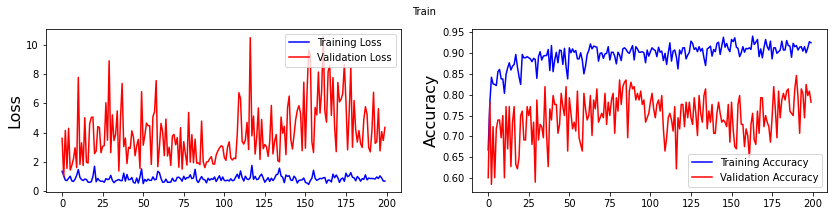

In [11]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Train', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [12]:
model.save(models_path+'xception_chest.h5')

In [13]:
model.save_weights(models_path+'xceptionweights_chest.hdf5')

In [14]:
model = load_model(models_path+'xception_chest.h5')

In [15]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size=32)
scores

188/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[4.357866381077057, 0.7819149]

### **Making Predicions**

In [16]:
y_pred = model.predict(X_test, batch_size=batch_size)

### Visulaizing First 10 predictions

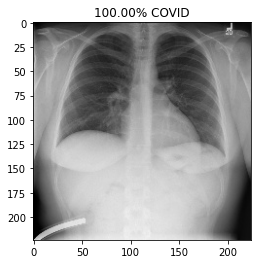

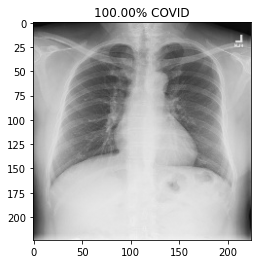

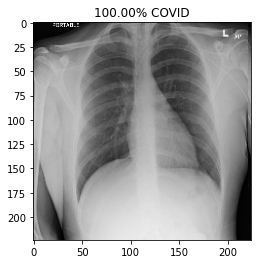

In [17]:
prediction=y_pred[12:15]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [18]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot Confusion Matrix

### **Classification Report**

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.91      0.59      0.71        87
           1       0.73      0.95      0.82       101

    accuracy                           0.78       188
   macro avg       0.82      0.77      0.77       188
weighted avg       0.81      0.78      0.77       188



Text(0.5, 1.0, 'Xception Model ')

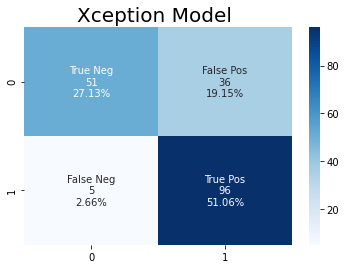

In [23]:
cf_matrix = confusion_matrix(y_test_bin,y_pred_bin)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
plt.title("Xception Model ", fontsize =20)